In [1]:
"""pip install scikit-optimize
pip install optuna
pip install fitter"""

'pip install scikit-optimize\npip install optuna\npip install fitter'

In [65]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================
#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Preprocesado y Modelado
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge


# Varios
# ==============================================================================================================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, classification_report, roc_curve


# <span style="color:darkred"> Objetivo </span>

<span style="color:darkblue"> Comparar variaros algoritmos en el problema de clasificación multiclase ejecutados con la técnica de optimización de validación cruzada RandomizedSearchCV.</span>



In [3]:
data=pd.read_excel(r"D:\Never Urueta\2023\Tesis\Data.xlsx") 

In [4]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [5]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


# <span style="color:darkred"> Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [6]:
data1 = data1.drop(["Ocupacion"],axis=1)

# <span style="color:darkred">Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [7]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

# <span style="color:darkred"> Variable de Respuesta </span>

In [8]:

data1.loc[data1["Rechazados"] > 1, "Rechazados"] = 2
print(data1.Rechazados.value_counts().sort_index())

0    1259
1     221
2     362
Name: Rechazados, dtype: int64


In [9]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   =0.66,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# <span style="color:darkred"> K-Nearest Neighbor (kNN)

In [10]:

from sklearn.neighbors import KNeighborsClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {
    'modelo__n_neighbors': range(1, 50, 2),
    'modelo__weights': ['uniform', 'distance'],
    'modelo__metric'   : ['euclidean', 'manhattan', 'minkowski'],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

_=grid.fit(X = X_train, y = y_train) 
param1 = grid.best_params_
mejor1 = grid.best_estimator_
predicciones1 = mejor1.predict(X = X_test)


# <span style="color:darkred"> Regresión lineal (Ridge y Lasso)¶

In [11]:
from sklearn.linear_model import RidgeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RidgeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500),
                       'modelo__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'lbfgs']}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

_=grid.fit(X = X_train, y = y_train) 
param2 = grid.best_params_
mejor2 = grid.best_estimator_
predicciones2 = mejor2.predict(X = X_test)


# <span style="color:darkred"> Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 100, 1000,10000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 1000]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

_=grid.fit(X = X_train, y = y_train) 
param3 = grid.best_params_
mejor3 = grid.best_estimator_
predicciones3 = mejor3.predict(X = X_test)


# <span style="color:darkred"> Árboles de decisión

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', DecisionTreeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 500],
    'modelo__max_depth'   : [None, 3, 5, 10, 300, 1000],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 20000],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

_=grid.fit(X = X_train, y = y_train) 
param4 = grid.best_params_
mejor4 = grid.best_estimator_
predicciones4 = mejor4.predict(X = X_test)


# <span style="color:darkred"> Resumen de Métricas

### <span style="color:darkorange"> knn

In [49]:
print('------------------------------------------------------')
print('      Algoritmo con K Nearest Neighbor - knn')
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones1))
print('------------------------------------------------------')

------------------------------------------------------
      Algoritmo con K Nearest Neighbor - knn
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       437
           1       0.00      0.00      0.00        64
           2       0.45      0.08      0.14       126

    accuracy                           0.70       627
   macro avg       0.39      0.35      0.32       627
weighted avg       0.58      0.70      0.60       627

------------------------------------------------------


### <span style="color:darkorange"> Ridge

In [50]:
print('------------------------------------------------------')
print('      Algoritmo con Regresión de Ridge')
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones2))
print('------------------------------------------------------')

------------------------------------------------------
      Algoritmo con Regresión de Ridge
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       437
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00       126

    accuracy                           0.70       627
   macro avg       0.23      0.33      0.27       627
weighted avg       0.49      0.70      0.57       627

------------------------------------------------------


### <span style="color:darkorange">Random Forest

In [52]:
print('------------------------------------------------------')
print('            Algoritmo Random Forest - rf')
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones3))
print('------------------------------------------------------')

------------------------------------------------------
            Algoritmo Random Forest - rf
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       437
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00       126

    accuracy                           0.70       627
   macro avg       0.23      0.33      0.27       627
weighted avg       0.49      0.70      0.57       627

------------------------------------------------------


### <span style="color:darkorange"> Arboles de Decisión

In [54]:
print('------------------------------------------------------')
print('        Algoritmo Arboles de Decisión - dtree')
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones4))
print('------------------------------------------------------')

------------------------------------------------------
        Algoritmo Arboles de Decisión - dtree
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       437
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00       126

    accuracy                           0.70       627
   macro avg       0.23      0.33      0.27       627
weighted avg       0.49      0.70      0.57       627

------------------------------------------------------


# <span style="color:darkred"> Stacking

<span style="color:darkblue"> Se crea un nuevo algoritmo con los hiperparámetros de los algoritmos escogidos

In [32]:
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_knn = Pipeline([('preprocessing', preprocessor),
                     ('knn', KNeighborsClassifier(weights='distance',n_neighbors=19, metric='manhattan'))])

pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', RidgeClassifier(solver='lsqr',alpha=23.59))])
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 100,
                                         max_features = 'log2',
                                         max_depth    = 20
                                        )
                     )])

pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 500,                 
                                         max_leaf_nodes = 100,
                                         max_features = 'auto',
                                         max_depth    = 10,
                                         criterion = 'gini'
                                        )
                     )])


In [40]:
# Definición y entrenamiento del StackingClassifier
# ==============================================================================
from sklearn.linear_model import LogisticRegression
estimators = [('random_forest', pipe_rf),
            ('Ridge', pipe_ridge),             
              ('knn', pipe_knn),
              ('Decision_Tree', pipe_dtree),
]
stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [41]:
stacking_model = stacking_cla
predicciones5 = stacking_model.predict(X = X_test)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicciones5))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       437
           1       1.00      0.02      0.03        64
           2       0.56      0.22      0.32       126

    accuracy                           0.72       627
   macro avg       0.76      0.40      0.39       627
weighted avg       0.73      0.72      0.65       627



In [61]:
recall_score(y_test,predicciones5,average=None)[0]

0.965675057208238

# <span style="color:darkred"> Gráfica Comparativa de Modelos por Métricas 

Text(0.5, 0, 'Test accuracy')

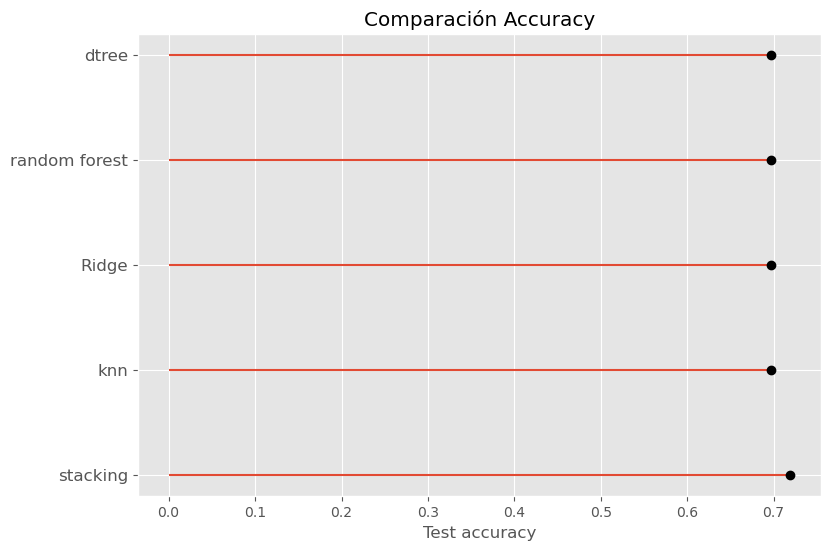

In [63]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'Ridge','random forest', 'dtree','stacking'],
                              'Accuracy': [accuracy_score(y_test,predicciones1), accuracy_score(y_test,predicciones2), accuracy_score(y_test,predicciones3), accuracy_score(y_test,predicciones4), accuracy_score(y_test,predicciones5)]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)


plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación Accuracy')
plt.xlabel('Test accuracy')

# Metricas Para el Stacking

array([[1244,    0,   15],
       [  82,   58,   81],
       [  98,    0,  264]], dtype=int64)

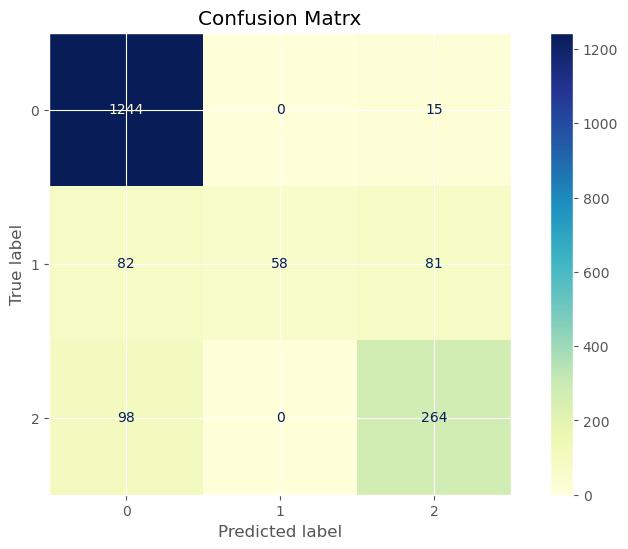

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')
disp =metrics.plot_confusion_matrix(stacking_model , data1.drop(["Rechazados"], axis=1), data1["Rechazados"], ax = ax, cmap="YlGnBu")
disp.confusion_matrix

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicciones5))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       437
           1       1.00      0.02      0.03        64
           2       0.56      0.22      0.32       126

    accuracy                           0.72       627
   macro avg       0.76      0.40      0.39       627
weighted avg       0.73      0.72      0.65       627



## Importancia de predictores
Importancia por permutación

In [68]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = stacking_cla,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'accuracy',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.125761,0.004242,Ti2
10,0.089053,0.004045,PPPCF
0,0.083128,0.004742,Dia_Semana
6,0.082963,0.002774,Temp3
12,0.078519,0.002363,Tamin
5,0.072593,0.002464,Ti1
3,0.072428,0.003413,Temp2
13,0.069465,0.003017,Taamax
1,0.067819,0.004526,Temp1
9,0.065350,0.004085,Canales


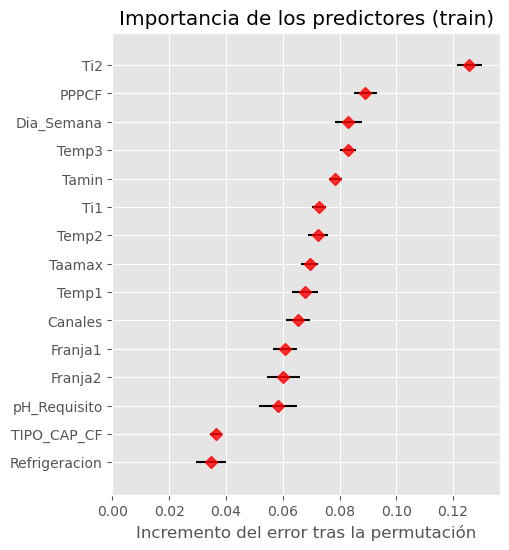

In [69]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');